In this notebook we will train a very simple classification model for labeling Cherenkov radiation shower images. The images will be classified as those caused by primary gammas (signal) and those initiated by cosmic rays in the upper atmosphere (background). You can find more information about the problem domain <a href="https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope" target="_blank" rel="noopener">here</a>.

We will train the model in this notebook using <a href="https://scikit-learn.org/stable/" target="_blank" rel="noopener">`scikit-learn`</a>, on the training data we are going to export from the database.

To execute queries and load data from Exasol database we will be using the <a href="https://github.com/exasol/pyexasol" target="_blank" rel="noopener">`pyexasol`</a> module.

Prior to using this notebook one needs to complete the follow steps:
1. [Create the database schema](../setup_db.ipynb).
2. [Load the MAGIC Gamma Telescope data](../data/data_telescope.ipynb).

In [1]:
# TODO: Move this to a separate configuration notebook. Here we just need to load this configuration from a store.
EXASOL_EXTERNAL_HOST_NAME = "192.168.124.93"
EXASOL_HOST_PORT = "8888"
EXASOL_EXTERNAL_HOST = f"""{EXASOL_EXTERNAL_HOST_NAME}:{EXASOL_HOST_PORT}"""
EXASOL_USER = "sys"
EXASOL_PASSWORD = "exasol"
EXASOL_BUCKETFS_PORT = "6666"
EXASOL_EXTERNAL_BUCKETFS_HOST = f"""{EXASOL_EXTERNAL_HOST_NAME}:{EXASOL_BUCKETFS_PORT}"""
EXASOL_BUCKETFS_USER = "w"
EXASOL_BUCKETFS_PASSWORD = "write"
EXASOL_BUCKETFS_USE_HTTPS = False
EXASOL_BUCKETFS_URL_PREFIX = "https://" if EXASOL_BUCKETFS_USE_HTTPS else "http://"
EXASOL_BUCKETFS_SERVICE = "bfsdefault"
EXASOL_BUCKETFS_BUCKET = "default"
EXASOL_BUCKETFS_PATH = f"/buckets/{EXASOL_BUCKETFS_SERVICE}/{EXASOL_BUCKETFS_BUCKET}" # Filesystem-Path to the read-only mounted BucketFS inside the running UDF Container
EXASOL_SCRIPT_LANGUAGE_NAME = "PYTHON3_60"
EXASOL_UDF_FLAVOR = "python3-ds-EXASOL-6.0.0"
EXASOL_UDF_RELEASE= "20190116"
EXASOL_UDF_CLIENT = "exaudfclient" # or for newer versions of the flavor exaudfclient_py3
EXASOL_SCRIPT_LANGUAGES = f"{EXASOL_SCRIPT_LANGUAGE_NAME}=localzmq+protobuf:///{EXASOL_BUCKETFS_SERVICE}/{EXASOL_BUCKETFS_BUCKET}/{EXASOL_UDF_FLAVOR}?lang=python#buckets/{EXASOL_BUCKETFS_SERVICE}/{EXASOL_BUCKETFS_BUCKET}/{EXASOL_UDF_FLAVOR}/exaudf/{EXASOL_UDF_CLIENT}";
EXASOL_SCHEMA = "IDA"

connection_params = {"dns": EXASOL_EXTERNAL_HOST, "user": EXASOL_USER, "password": EXASOL_PASSWORD, "compression": True}

params = {
    "script_languages": EXASOL_SCRIPT_LANGUAGES,
    "script_language_name": EXASOL_SCRIPT_LANGUAGE_NAME,
    "schema": EXASOL_SCHEMA,
    "EXASOL_BUCKETFS_PORT": EXASOL_BUCKETFS_PORT,
    "EXASOL_BUCKETFS_USER": EXASOL_BUCKETFS_USER,
    "EXASOL_BUCKETFS_PASSWORD": EXASOL_BUCKETFS_PASSWORD,
    "EXASOL_BUCKETFS_USE_HTTPS": EXASOL_BUCKETFS_USE_HTTPS,
    "EXASOL_BUCKETFS_BUCKET": EXASOL_BUCKETFS_BUCKET,
    "EXASOL_BUCKETFS_PATH": EXASOL_BUCKETFS_PATH
}

First we will export data into a pandas DataFrame.

In [2]:
import pyexasol
from stopwatch import Stopwatch

stopwatch = Stopwatch()

with pyexasol.connect(dsn=EXASOL_EXTERNAL_HOST, user=EXASOL_USER, password=EXASOL_PASSWORD, compression=True) as conn:
    df = conn.export_to_pandas(query_or_table=(EXASOL_SCHEMA, 'TELESCOPE_TRAIN'))

print(f"Loading the data took: {stopwatch}")

Loading the data took: 1.23s


The data has no missing values. In order to keep things simple we will be using a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier" target="_blank" rel="noopener">`Decision Tree Classifier`</a> algorithm which requires little in terms of pre-processing for this dataset.

In [4]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets. Use all available features columns.
X, y = df.drop(columns='CLASS'), df['CLASS']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

stopwatch = Stopwatch()

# Create and train the model.
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

print(f"Training took: {stopwatch}")

Training took: 138.81ms


Let's evaluate the model using the validation set.
The results may not look particularly impressive but it's OK. We are aiming for simplicity and clarity, not the best prediction performance.

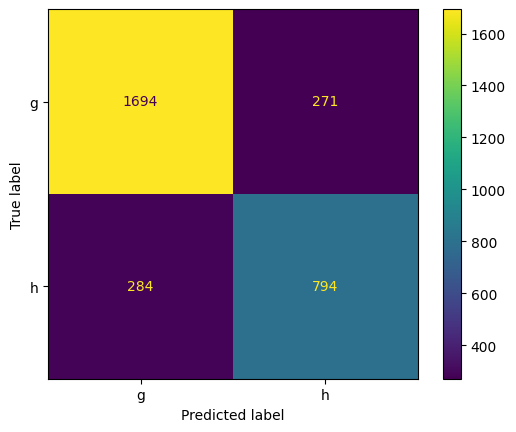

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make the predictions on the validation set.
y_pred = model.predict(X_valid)

# Build and display the confusion matrix.
cm = confusion_matrix(y_valid, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

Now, let's upload the model into BucketFS, so that it can be used for making classification in SQL queries. To communicate with BucketFS we will be using the <a href="https://exasol.github.io/bucketfs-python/" target="_blank" rel="noopener">`bucketfs-python`</a> module. 

In [6]:
import pickle
from exasol.bucketfs import Service

MODEL_FILE = 'telescope_tree_model.pkl'

# Setup the connection parameters.
buckfs_url = f'{EXASOL_BUCKETFS_URL_PREFIX}{EXASOL_EXTERNAL_BUCKETFS_HOST}'
buckfs_credentials = {EXASOL_BUCKETFS_BUCKET: {'username': EXASOL_BUCKETFS_USER, 'password': EXASOL_BUCKETFS_PASSWORD}}

stopwatch = Stopwatch()

# Connect to the BucketFS service and navigate to the bucket of choice.
bucketfs = Service(buckfs_url, buckfs_credentials)
bucket = bucketfs[EXASOL_BUCKETFS_BUCKET]

# Serialize model into a byte-array and upload it to the BucketFS, 
# where it will be saved in the file with the specified name.
bucket.upload(MODEL_FILE, pickle.dumps(model))

print(f"Uploading the model took: {stopwatch}")

Uploading the model took: 768.74ms


Now we are ready to use this model in our SQL queries. This will be demonstrated in the [following notebook](sklearn_predict_telescope.ipynb)